## Лабораторная работа № 2 
## Машинное обучение на больших данных с использованием фреймворка Apache Spark и библиотеки SparkML

### Часть 2

В данной части работы рассмотрены:
* подготовка признаков для решения задачи бинарной классификации с использованием **логистической регрессии**;
* создание и обучение модели логистической регрессии;
* оценка качества модели.


#### Запуск `Spark`-сессии

Подключаем необходимые библиотеки.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.ml.feature import VectorAssembler, StringIndexer, Binarizer, Bucketizer
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import Window

Сформируем объект конфигурации для `Apache Spark`, указав необходимые параметры.

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 2.2 Test Kachurin")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

Создаём сам объект конфигурации.

In [3]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`. В процессе создания сессии происходит подключение к кластеру `Apache Hadoop`, что может занять некоторое время.

In [4]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

:: loading settings :: url = jar:file:/opt/spark-3.5.2-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/user6/.ivy2/cache
The jars for the packages stored in: /home/user6/.ivy2/jars
org.apache.iceberg#iceberg-spark-runtime-3.5_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8cdb2a89-89d4-46c6-8f39-cd7136661e36;1.0
	confs: [default]
	found org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 in central
:: resolution report :: resolve 696ms :: artifacts dl 23ms
	:: modules in use:
	org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spa

#### Загрузка датасета

Укажем базу данных, которая была создана в первой лабораторной работе.

In [5]:
database_name = "kachurin_database"

Установим созданную базу данных как текущую.

In [6]:
spark.catalog.setCurrentDatabase(database_name)

Прочитаем таблицу с **предобработанным датасетом** и загрузим её в `Spark Dataframe`.

In [7]:
df = spark.table("sobd_lab1_processed_table_1")

Выведем прочитанную таблицу на экран.

In [8]:
df.show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|airportFlights|totalFlights|otherAirportsFlights|relativeFlightShareOtherAirports|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|f38c6c38eddff88d2...|2022-07-01|            ATL|               BOS|         false|       false|    false|320.92999267578125| 368.6000061035156|             1|              947.0|             6|         173|       

Вспомним описание столбцов и параметры датасета, проанализированные в первой лабораторной работе.

| Название столбца            | Расшифровка                                                                 |
| --------------------------- | --------------------------------------------------------------------------- |
| legId                       | Идентификатор рейса                                                        |
| flightDate                  | Дата вылета (YYYY-MM-DD)                                                   |
| startingAirport             | Код аэропорта вылета (IATA)                                               |
| destinationAirport          | Код аэропорта прилета (IATA)                                              |
| isBasicEconomy              | Является ли билет экономичным (логическое значение)                       |
| isRefundable                | Является ли билет возвратным (логическое значение)                        |
| isNonStop                   | Является ли рейс прямым (логическое значение)                             |
| baseFare                    | Базовая стоимость билета (в долларах США)                                 |
| totalFare                   | Полная стоимость билета с учетом налогов и сборов (в долларах США)        |
| seatsRemaining              | Количество оставшихся мест                                                |
| totalTravelDistance         | Общая дистанция путешествия (в милях)                                     |


Вспомним схему данных.

In [9]:
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: float (nullable = true)
 |-- airportFlights: long (nullable = true)
 |-- totalFlights: long (nullable = true)
 |-- otherAirportsFlights: long (nullable = true)
 |-- relativeFlightShareOtherAirports: double (nullable = true)



Вычислим количество строк в датафрейме.

In [10]:
df.count()

30655206

#### Постановка задачи

Для датасета, заданного представленными колонками, требуется построить модель бинарной классификации с использованием **логистической регрессии**  для оценки факта того, является ли билет экономичным (значение isBasicEconomy), по всем остальным признакам. 

Для оценки качества обучения следует использовать метрики `Precision` и `Recall`. Оценить максимально возможное значение **точности** при полноте не менее 60%.


#### Подготовка и кодирование признаков

Для корректной работы трансформеров и модели преобразуем столбец `totalTravelDistance` к типу `DoubleType`, а столбец `isBasicEconomy` к типу `IntegerType`.

In [11]:
df = df.withColumn("totalTravelDistance", F.col("totalTravelDistance").cast(DoubleType()))
df = df.withColumn("isBasicEconomy", F.col("isBasicEconomy").cast(IntegerType()))

Выполним **стратифицированное** разделение датасета на обучающую и тестовую выборки.

In [12]:
def stratified_train_test_split(data: DataFrame, 
                                label_col: str,
                                ratio: float) -> tuple[DataFrame, DataFrame]:
    """
    Разделяет DataFrame на тренировочный и тестовый наборы с учетом стратификации.

    Args:
        data: Исходный DataFrame.
        label_col: Название столбца с меткой.
        ratio: Пропорция разделения данных.

    Returns:
        tuple[DataFrame, DataFrame]: Кортеж из тренировочного и тестового DataFrame.
    """
    # Проверяем корректность доли разделения
    assert (isinstance(ratio, float) and (0.0 <= ratio <= 1.0))
    
    # Формируем разделение для положительных и отрицательных объектов раздельно
    train_df_pos, test_df_pos = (data
                                 .filter(F.col(label_col) == 1)
                                 .randomSplit([ratio, 1 - ratio]))
    train_df_neg, test_df_neg = (data
                                 .filter(F.col(label_col) == 0)
                                 .randomSplit([ratio, 1 - ratio]))
    
    # Объединяем датафреймы
    return (train_df_pos.union(train_df_neg),
            test_df_pos.union(test_df_neg))

In [13]:
train_df, test_df = stratified_train_test_split(df, "isBasicEconomy", 0.8)

Закешируем сформированные датафреймы и проверим их объем.

In [14]:
train_df = train_df.cache()
test_df = test_df.cache()

print(f"Train dataset size: {train_df.count()}")
print(f"Test  dataset size: {test_df.count()}")

Train dataset size: 24521787


Test  dataset size: 6133419


Как мы уже знаем из анализа датасета, если целевой переменной является `isBasicEconomy`, то датасет является **несбалансированным**.

In [15]:
train_df.groupBy("isBasicEconomy").count().show()

+--------------+--------+
|isBasicEconomy|   count|
+--------------+--------+
|             1| 2379869|
|             0|22141918|
+--------------+--------+



Выполним балансировку датасета с помощью `oversampling`. 

In [16]:
def oversample(data: DataFrame, column: str) -> DataFrame:
    """
    Выполняет oversampling положительных классов в DataFrame.

    Args:
        data: Исходный DataFrame.
        column: Название столбца с меткой.

    Returns:
        DataFrame: Датафрейм с выполненным oversampling.
    """
    # Разделим датафрейм на положительные и отрицательные классы
    pos = data.filter(F.col(column) == 1.0)
    neg = data.filter(F.col(column) == 0.0)

    # Получим количество записей в каждом классе
    total_pos = pos.count()
    total_neg = neg.count()

    # Если количество положительных классов меньше отрицательных,
    # выполним oversampling
    if total_pos < total_neg:
        # Вычислим количество необходимых дубликатов
        num_duplicates = total_neg - total_pos

        # Дублируем положительные записи
        oversampled_pos = pos.withColumn(
            "dummy",
            F.explode(
                F.array_repeat(F.lit(1),
                               num_duplicates // total_pos + 1)
            )
        ).drop("dummy")

        # Объединим дублированные положительные записи с отрицательными
        balanced_df = neg.union(oversampled_pos)
    else:
        balanced_df = data

    return balanced_df

In [17]:
train_df = oversample(train_df, column="isBasicEconomy")

Проверим баланс классов в получившемся датасете.

In [18]:
train_df.groupBy("isBasicEconomy").count().show()

+--------------+--------+
|isBasicEconomy|   count|
+--------------+--------+
|             0|22141918|
|             1|21418821|
+--------------+--------+



Понятно, что **идентификационный номер** автомобиля не оказывает влияния на сертификацию. Использовать его в модели нет смысла.

Остальные признаки сгруппируем по их типу:

* **Категориальные** признаки закодируем с помощью `label encoding`.
* **Бинарные** признаки представлены значениями `true` / `false`, которые могут быть интерпретированы как единица и нуль. Поэтому, в кодировании не нуждаются.
* **Количественные** признаки для древовидных моделей в кодировании не нуждаются.


In [19]:
categorical_features = ["startingAirport", "destinationAirport"]
binary_features = ["isRefundable", "isNonStop"]
numeric_features = [
    "baseFare", "totalFare", "seatsRemaining", 
    "totalTravelDistance", "airportFlights"
]

In [20]:
# categorical_features = ["body_type", "wheel_system"]
# binary_features = [
#     "contains_Alloy Wheels", "contains_Backup Camera", "contains_Bluetooth", 
#     "contains_Heated Seats", "contains_Sunroof/Moonroof"
# ]
# numeric_features = ["daysonmarket", "horsepower", "price", "maximum_seating", "age"]
# binarizable_feature = "mileage"

Создадим конвейер обработки данных, включающий модель градиентного бустинга на деревьях решений.

In [21]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

def create_pipeline(categorical_features: list[str], numeric_features: list[str], 
                    label_col: str, max_iter: int) -> Pipeline:
    """
    Создает конвейер для обработки данных и обучения модели логистической регрессии.

    Args:
        categorical_features: Список категориальных признаков.
        numeric_features: Список количественных признаков.
        label_col: Название столбца с меткой.
        max_iter: Максимальное количество итераций для модели.

    Returns:
        Pipeline: Конвейер для обработки данных и обучения модели.
    """
    # Преобразование категориальных признаков в индексы
    indexed_categorical_features = [f"{feature}_index" for feature in categorical_features]
    string_indexer = StringIndexer(
        inputCols=categorical_features,
        outputCols=indexed_categorical_features
    )

    # One-hot encoding для категориальных признаков
    encoded_categorical_features = [f"{feature}_encoded" for feature in categorical_features]
    one_hot_encoder = OneHotEncoder(
        inputCols=indexed_categorical_features,
        outputCols=encoded_categorical_features
    )

    # Векторизация всех признаков
    vector_all_assembler = VectorAssembler(
        inputCols=(encoded_categorical_features + numeric_features),
        outputCol="features"
    )

    # Логистическая регрессия
    logistic_regression = LogisticRegression(
        featuresCol="features",
        labelCol=label_col,
        predictionCol="prediction",
        maxIter=max_iter
    )

    # Конвейер
    pipeline = Pipeline(stages=[
        string_indexer, one_hot_encoder, vector_all_assembler, logistic_regression
    ])

    return pipeline


In [22]:
pipeline = create_pipeline(categorical_features=categorical_features,
                           numeric_features=numeric_features,
                           label_col="isBasicEconomy",
                           max_iter=30)

#### Обучение модели

Выполним **подбор гиперпараметров** модели линейной регрессии с помощью кросс-валидации на сетке.

Создаем сетку параметров для кросс-валидации, получив объект `GBTClassifier` из конвейера.

In [23]:
# param_grid = ParamGridBuilder() \
#     .addGrid(pipeline.getStages()[-1].maxDepth, [3, 5, 7]) \
#     .addGrid(pipeline.getStages()[-1].stepSize, [0.1, 0.01, 0.001]) \
#     .build()

# Подбор гиперпараметров, указанный выше, выполняется на кластере несколько часов :))
# Для ознакомления можно использовать упрощенную процедуру, приведенную ниже
param_grid = ParamGridBuilder() \
    .addGrid(pipeline.getStages()[-1].regParam, [0.01]) \
    .addGrid(pipeline.getStages()[-1].elasticNetParam, [0.0]) \
    .addGrid(pipeline.getStages()[-1].maxIter, [30]) \
    .build()

Создаем экземпляр `BinaryClassificationEvaluator` для оценки модели.

In [24]:
cv_evaluator = BinaryClassificationEvaluator(labelCol="isBasicEconomy")

Создаем объект `CrossValidator`.

In [25]:
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=cv_evaluator,
                                 numFolds=5)

Обучаем модель конвейера с использованием кросс-валидации.

In [26]:
cv_model = cross_validator.fit(train_df)

24/12/20 04:39:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Выведем параметры **лучшей** модели, определенной в ходе кросс-валидации.

In [27]:
def get_best_model_params(cv_model: CrossValidatorModel) -> dict[str, float]:
    """
    Получает параметры лучшей модели из объекта CrossValidatorModel.

    Args:
        cv_model: Объект CrossValidatorModel, содержащий лучшую модель.

    Returns:
        Dict[str, float]: Параметры лучшей модели.
    """
    best_model = cv_model.bestModel
    # Получаем параметры из логистической регрессии
    best_params = {
        "regParam": best_model.stages[-1].getRegParam(),  # Параметр регуляризации
        "elasticNetParam": best_model.stages[-1].getElasticNetParam(),  # Параметр эластичной сети
        "maxIter": best_model.stages[-1].getMaxIter()  # Количество итераций
    }
    return best_params


In [28]:
for key, value in get_best_model_params(cv_model=cv_model).items():
    print(f"{key}: {value}")

regParam: 0.01
elasticNetParam: 0.0
maxIter: 30


#### Анализ обученной модели

Рассчитаем метрики на тестовом датасете.

In [29]:
# Получаем датасет предсказаний
test_df_predictions = cv_model.transform(test_df)

# Извлекаем список колонок, устанавливаем цену на последнее место
right_columns_order = test_df_predictions.columns
right_columns_order.remove("isBasicEconomy")
right_columns_order.append("isBasicEconomy")

# Изменяем последовательность колонок и выводим датафрейм
test_df_predictions = test_df_predictions.select(*right_columns_order)
test_df_predictions.show()

+--------------------+----------+---------------+------------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+---------------------+------------------------+-----------------------+--------------------------+--------------------+--------------------+--------------------+----------+--------------+
|               legId|flightDate|startingAirport|destinationAirport|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|airportFlights|totalFlights|otherAirportsFlights|relativeFlightShareOtherAirports|startingAirport_index|destinationAirport_index|startingAirport_encoded|destinationAirport_encoded|            features|       rawPrediction|         probability|prediction|isBasicEconomy|
+--------------------+----------+---------------+------------------+------------+---------+------------------+------------------+---

In [30]:
def evaluate_model(data: DataFrame, 
                   label_col: str) -> dict[str, float]:
    """
    Оценивает модель с использованием метрик точности, полноты и F1-score.

    Args:
        data: DataFrame, содержащий предсказания и фактические метки.
        label_col: Название колонки с меткой.

    Returns:
        dict[str, float]: Словарь с метриками точности, полноты и F1-score.
    """
    # Вычисляем TP, FP, FN
    tp = data.filter((F.col(label_col) == 1) &
                     (F.col("prediction") == 1)).count()
    fp = data.filter((F.col(label_col) == 0) &
                     (F.col("prediction") == 1)).count()
    fn = data.filter((F.col(label_col) == 1) &
                     (F.col("prediction") == 0)).count()

    # Вычисляем метрики
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0 else 0)

    # Возвращаем словарь с метриками
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [31]:
metrics = evaluate_model(test_df_predictions, "isBasicEconomy")
print(f"Metrics: {metrics}")

Metrics: {'precision': 0.41312069864133333, 'recall': 0.9365529858010808, 'f1': 0.5733377308436027}


Наблюдаем довольно низкую точность при высокой полноте. Попробуем подобрать `threshold`, чтобы максимизировать точность, но при этом удерживать полноту на заданном в постановке задачи уровне.
Сначала рассчитаем `AUC ROC`, визуализируем `ROC` и `PR`-кривые и оценим ситуацию.

In [32]:
def calculate_auc_roc(model: LogisticRegressionModel, 
                      test_data: DataFrame,
                      label_col: str) -> float:
    """
    Рассчитывает значение AUC ROC для модели.

    Args:
        model: Обученная модель классификации.
        test_data: Тестовый набор данных.
        label_col: Название столбца с меткой.

    Returns:
        float: Значение AUC ROC.
    """
    # Получаем прогнозы модели
    predictions = model.transform(test_data)

    # Создаем "оценщик" бинарной классификации
    evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="rawPrediction",
        labelCol=label_col
    )

    # Вычисляем AUC ROC
    auc_roc = evaluator.evaluate(predictions)

    return auc_roc

In [33]:
def prepare_metrics_df(predictions: DataFrame, label_col: str) -> DataFrame:
    """
    Подготавливает DataFrame для расчета FPR, TPR и Precision.

    Args:
        predictions: DataFrame с прогнозами модели.
        label_col: Название столбца с меткой.

    Returns:
        DataFrame: DataFrame с рассчитанными столбцами FPR, TPR и Precision.
    """
    # Формируем датафрейм, содержащий результат предсказания,
    # вероятность предсказания и метку
    metrics_df = (
        predictions
        .select(
            vector_to_array(
                F.col("probability")
            ).getItem(1).alias("probability"),
            
            F.col(label_col).alias("label"),
            F.col("prediction").cast("int").alias("prediction")
        )
    )

    # Сортируем датафрейм по значениям вероятности
    metrics_df = metrics_df.orderBy("probability")

    # Рассчитываем количество положительных и отрицательных классов
    pos_count = metrics_df.filter(metrics_df.label == 1).count()
    neg_count = metrics_df.filter(metrics_df.label == 0).count()

    # Рассчитываем значения FPR и TPR
    window = Window.partitionBy().orderBy(F.desc("probability"))
    metrics_df = (
        metrics_df
        .withColumn("FP_cum", 
                    F.sum(F.when(
                        F.col("label") == 0, 1
                    ).otherwise(0)).over(window))
        .withColumn("TP_cum", F.sum(F.col("label")).over(window))
        .withColumn("FPR", F.col("FP_cum") / neg_count)
        .withColumn("TPR", F.col("TP_cum") / pos_count)
        .withColumn("Precision", 
                    F.col("TP_cum") / (F.col("TP_cum") + F.col("FP_cum")))
    )

    return metrics_df

In [34]:
# def bucketize_metrics_df(metrics_df: DataFrame, 
#                          num_buckets: int = 1000) -> DataFrame:
#     """
#     Применяет Bucketizer к DataFrame для уменьшения объёма данных, 
#     возвращаемых на драйвер.

#     Args:
#         metrics_df: DataFrame с рассчитанными столбцами FPR, TPR и Precision.
#         num_buckets: Количество бакетов.

#     Returns:
#         DataFrame: Бакетизированный Dataframe.
#     """
#     # Определяем границы бакетов
#     bucketizer = Bucketizer(
#         splits=list(np.linspace(0, 1, num_buckets + 1)),
#         inputCol="probability",
#         outputCol="bucket"
#     )

#     # Применяем Bucketizer
#     metrics_df = bucketizer.setHandleInvalid("error").transform(metrics_df)

#     # Формируем одну точку из каждого бакета
#     metrics_df = metrics_df.groupBy("bucket").agg(
#         F.avg(F.col("probability")).alias("probability"),
#         F.avg(F.col("FPR")).alias("FPR"),
#         F.avg(F.col("TPR")).alias("TPR"),
#         F.avg(F.col("Precision")).alias("Precision")
#     )

#     return metrics_df

In [35]:
from pyspark.ml.feature import Bucketizer
import numpy as np
from pyspark.sql import functions as F

def bucketize_metrics_df(metrics_df: DataFrame, 
                         num_buckets: int = 1000) -> DataFrame:
    """
    Применяет Bucketizer к DataFrame для уменьшения объёма данных, 
    возвращаемых на драйвер.

    Args:
        metrics_df: DataFrame с рассчитанными столбцами FPR, TPR и Precision.
        num_buckets: Количество бакетов.

    Returns:
        DataFrame: Бакетизированный DataFrame.
    """
    # Проверяем, что колонка probability является скалярной
    if "probability" not in metrics_df.columns:
        raise ValueError("Column 'probability' not found in DataFrame.")

    # Определяем границы бакетов
    bucketizer = Bucketizer(
        splits=list(np.linspace(0, 1, num_buckets + 1)),
        inputCol="probability",  # Используем scalar probability
        outputCol="bucket"
    )

    # Применяем Bucketizer
    metrics_df = bucketizer.setHandleInvalid("error").transform(metrics_df)

    # Формируем одну точку из каждого бакета
    metrics_df = metrics_df.groupBy("bucket").agg(
        F.avg(F.col("probability")).alias("probability"),
        F.avg(F.col("FPR")).alias("FPR"),
        F.avg(F.col("TPR")).alias("TPR"),
        F.avg(F.col("Precision")).alias("Precision")
    )

    return metrics_df


In [36]:
# def calculate_metrics(model: GBTClassificationModel, 
#                       test_data: DataFrame,
#                       label_col: str) -> pd.DataFrame:
#     """
#     Рассчитывает значения FPR, TPR и Precision для построения ROC и PR-кривых.

#     Args:
#         model: Обученная модель классификации.
#         test_data: Тестовый набор данных.
#         label_col: Название столбца с меткой.

#     Returns:
#         tuple[float, pd.DataFrame]: Кортеж из значения AUC ROC и DataFrame 
#                                     со значениями FPR, TPR и Precision.
#     """
#     # Получаем прогнозы модели
#     predictions = model.transform(test_data)

#     # Подготавливаем DataFrame для расчета FPR, TPR и Precision
#     metrics_df = prepare_metrics_df(predictions, label_col)

#     # Применяем Bucketizer к DataFrame
#     metrics_df = bucketize_metrics_df(metrics_df)

#     return metrics_df.toPandas()

In [37]:
def calculate_metrics(model: LogisticRegressionModel, 
                      test_data: DataFrame,
                      label_col: str) -> pd.DataFrame:
    """
    Рассчитывает значения FPR, TPR и Precision для построения ROC и PR-кривых.

    Args:
        model: Обученная модель классификации.
        test_data: Тестовый набор данных.
        label_col: Название столбца с меткой.

    Returns:
        tuple[float, pd.DataFrame]: Кортеж из значения AUC ROC и DataFrame 
                                    со значениями FPR, TPR и Precision.
    """
    # Получаем прогнозы модели
    predictions = model.transform(test_data)

    # Подготавливаем DataFrame для расчета FPR, TPR и Precision
    metrics_df = prepare_metrics_df(predictions, label_col)

    # Применяем Bucketizer к DataFrame
    metrics_df = bucketize_metrics_df(metrics_df)

    return metrics_df.toPandas()


In [38]:
def plot_roc_pr_curves(pd_data: pd.DataFrame, 
                       auc_roc: float) -> None:
    """
    Визуализирует ROC и PR-кривые, добавляет на график AUC ROC.

    Args:
        pd_data: Pandas DataFrame, содержащий столбцы 
            "FPR", "TPR", "Precision".
        auc_roc: Значение AUC-ROC.

    Returns:
        None
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Построение ROC-кривой
    sns.lineplot(x="FPR", y="TPR", data=pd_data, ax=axes[0])
    sns.lineplot(x=[0, 1], y=[0, 1], 
                 color="gray", linestyle="--", ax=axes[0])
    axes[0].set_xlabel("False Positive Rate (FPR)")
    axes[0].set_ylabel("True Positive Rate (TPR)")
    axes[0].set_title("ROC Curve")
    axes[0].grid()

    # Добавляем значение AUC-ROC в правом нижнем углу графика
    axes[0].text(0.94, 0.06, f'AUC-ROC: {auc_roc:.2f}', 
                 transform=axes[0].transAxes,
                 fontsize=12, verticalalignment='bottom', 
                 horizontalalignment='right',
                 bbox=dict(facecolor='white', 
                           alpha=0.8), zorder=5)

    # Построение PR-кривой
    sns.lineplot(x="TPR", y="Precision", 
                 data=pd_data, ax=axes[1])
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("PR Curve")
    axes[1].grid()

    plt.tight_layout()
    plt.show()

In [39]:
test_df.show()

+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|               legId|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|          baseFare|         totalFare|seatsRemaining|totalTravelDistance|airportFlights|totalFlights|otherAirportsFlights|relativeFlightShareOtherAirports|
+--------------------+----------+---------------+------------------+--------------+------------+---------+------------------+------------------+--------------+-------------------+--------------+------------+--------------------+--------------------------------+
|0003f8a28b5a37580...|2022-10-06|            LGA|               LAX|             1|       false|    false|199.07000732421875|237.60000610351562|             9|             2659.0|          5553|       76330|       

24/12/20 05:16:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/20 05:16:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/20 05:16:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/20 05:16:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/20 05:17:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/20 05:17:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/20 0

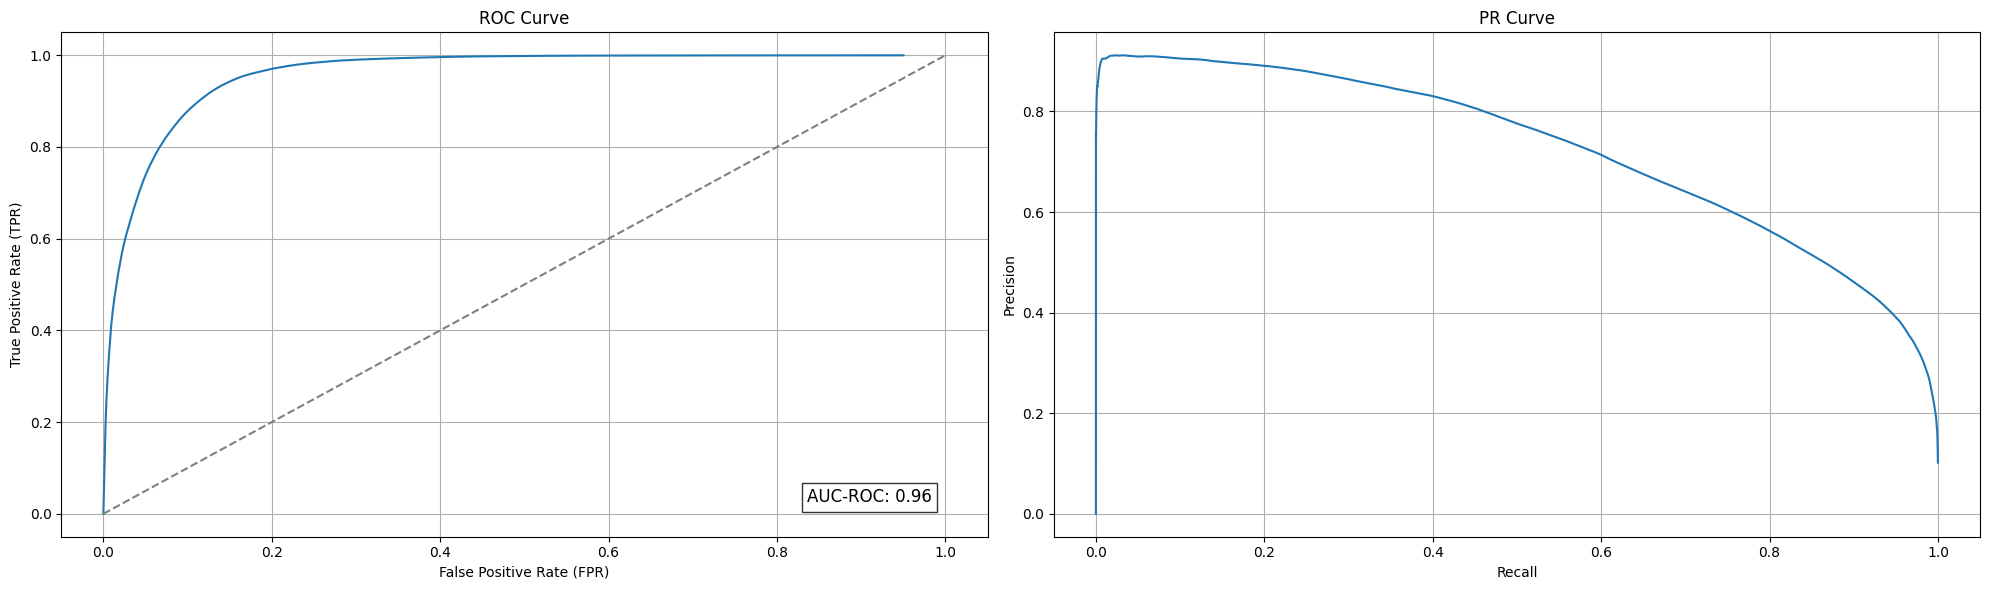

In [40]:
# Рассчитываем AUC ROC
auc_roc = calculate_auc_roc(model=cv_model,
                            test_data=test_df,
                            label_col="isBasicEconomy")
pd_dataframe = calculate_metrics(model=cv_model,
                                  test_data=test_df,
                                  label_col="isBasicEconomy") 
plot_roc_pr_curves(pd_dataframe, auc_roc)


In [41]:
print(cv_model)
print (auc_roc)

CrossValidatorModel_b384ac543746
0.9589615566897857


Определим вероятность -- границу разделения, при которой `Recall` не меньше 60%.

In [42]:
threshold_probability = pd_dataframe[pd_dataframe['TPR'] >= 0.60]['probability'].max()
print(f"Вероятность -- граница разделения, при которой TPR не меньше 60%: {threshold_probability:.2f}")

Вероятность -- граница разделения, при которой TPR не меньше 60%: 0.84


Рассчитаем метрики на тестовом датасете повторно, с учетом вычисленного `threshold` для вероятности.

In [43]:
cv_model.bestModel.stages[-1].setThresholds([1 - threshold_probability, 
                                             threshold_probability])
test_df_predictions = cv_model.transform(test_df)
metrics = evaluate_model(test_df_predictions, "isBasicEconomy")
print(f"Metrics: {metrics}")

Metrics: {'precision': 0.7128671684984456, 'recall': 0.6011261790473633, 'f1': 0.6522454896261858}


Обученная модель обладает не очень хорошим качеством. Для дальнейшего улучшения качества предсказания можно подобрать другую модель, сформировать другие признаки, добавить к модели дополнительные данные и т.д.

Не забываем завершать `Spark`-сессию.

In [44]:
spark.stop()